In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from datetime import date
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
from statsmodels.tsa.seasonal import STL
import backtrader as bt

sns.set()
%matplotlib inline

In [2]:
def loadPrices(fileName):
    dat = pd.read_csv(fileName, index_col=0)
    dat = dat.iloc[2:]
    dat.index = pd.DatetimeIndex(dat.index)
    
    # Приводим нужные колонки к integer (после округления)
    cols_to_round = ['High', 'Low', 'Close', 'Open']
    for col in cols_to_round:
        if col in dat.columns:
            dat[col] = pd.to_numeric(dat[col], errors='coerce').round(2)
    return dat

In [3]:
def normalizeValues(table, newColumn, existingColum):
    priceAtT0 = table.iloc[0][existingColum]
    table[newColumn] = table.apply(lambda row: (row[existingColum] / priceAtT0), axis=1)
    return table

In [4]:
path_csv_SPX = "data/spx_data_yahoo.csv"
spx = loadPrices(path_csv_SPX)
spx = spx.loc["2009-01-01":]
spx = normalizeValues(spx, 'procent', 'Close')

In [5]:
spx.head()

,Open,High,Low,Close,Volume,procent
Price,,,,,,
2009-01-02,902.99,934.73,899.35,931.80,4048270000,1.000000
2009-01-05,929.17,936.63,919.53,927.45,5413910000,0.995332
2009-01-06,931.17,943.85,927.28,934.70,5392620000,1.003112
2009-01-07,927.45,927.45,902.37,906.65,4704940000,0.973009
2009-01-08,905.73,910.00,896.81,909.73,4991550000,0.976315


In [6]:
all_days = spx.shape[0]
all_days

4094

In [7]:
# Преобразуем дату в числа
spx['date_number'] = np.array([((i * 10 / all_days) + 1) for i in range(1, all_days + 1)])

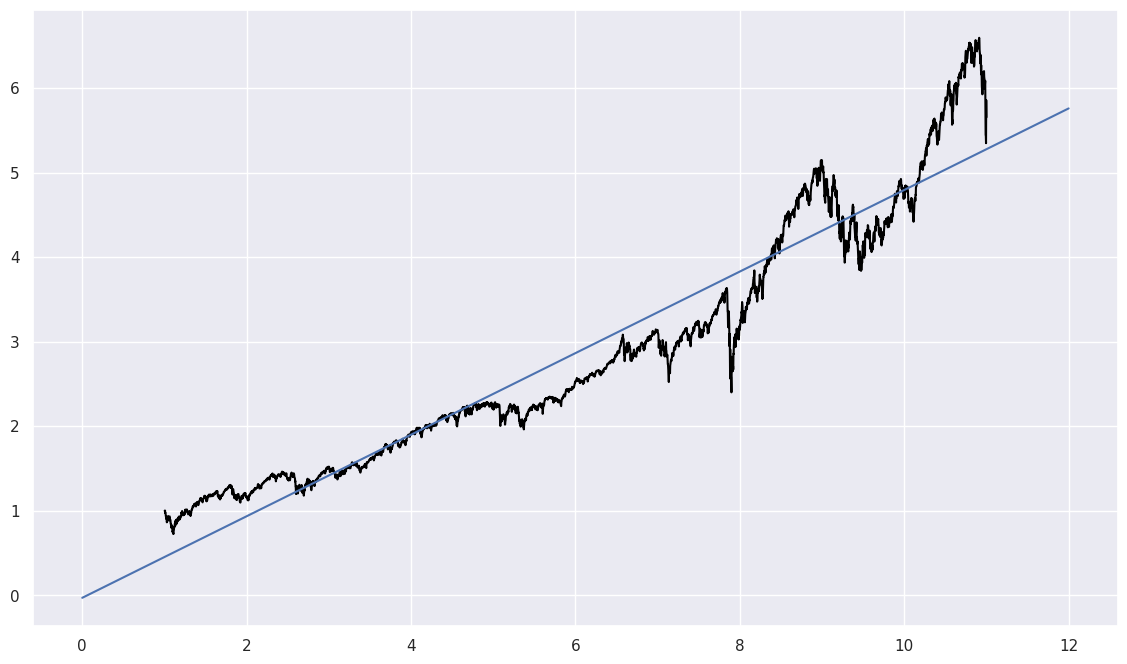

In [8]:
Xaxis = spx['date_number'].values
Yaxis = spx['procent'].values

model = LinearRegression()
model.fit(Xaxis.reshape(-1, 1), Yaxis)

# Прорисовываем наш график
plt.figure(figsize=(14, 8))
plt.plot(Xaxis, Yaxis, c='black')

# Узнаем размеры нашего графика
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(math.floor(xlim[0]), math.ceil(xlim[1]))
yy = np.linspace(math.floor(ylim[0]), math.floor(ylim[1]))

# Рисуем предсказаную модель
y_predict = model.predict(xx.reshape(-1, 1))
plt.plot(xx, y_predict)

### логаримическая

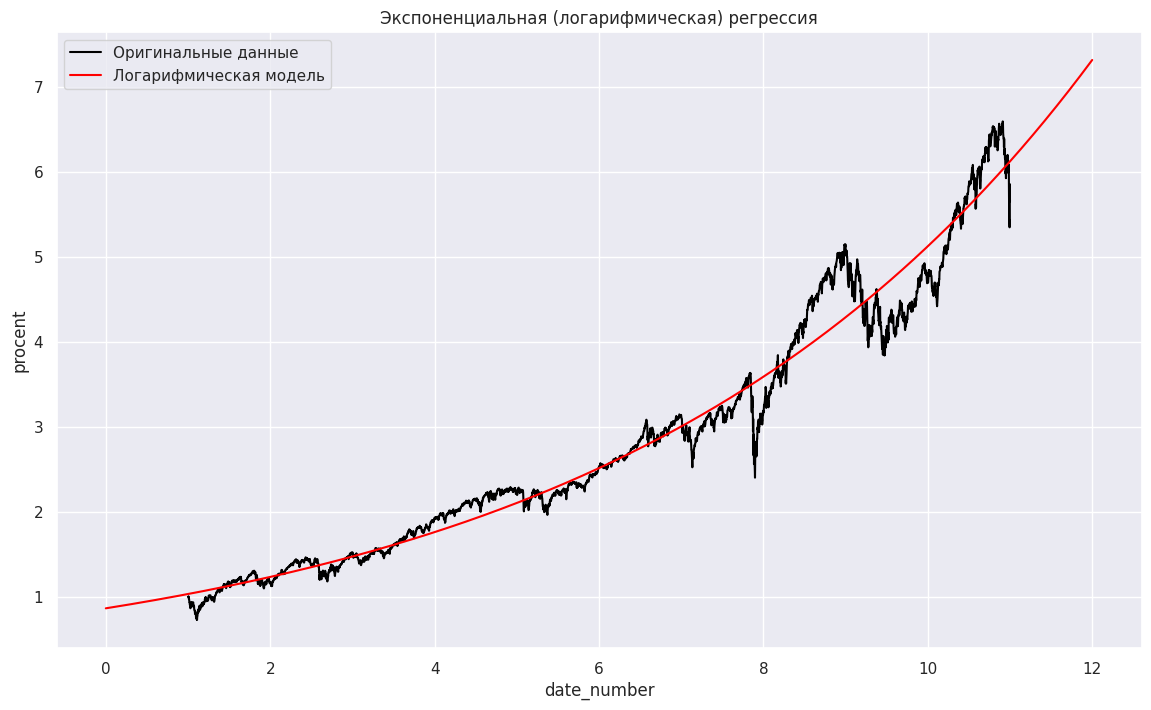

In [9]:
Xaxis = spx['date_number'].values
Yaxis = spx['procent'].values

# Преобразуем Yaxis в логарифм
log_Yaxis = np.log(Yaxis)

# Обучаем модель на логарифме Y
model = LinearRegression()
model.fit(Xaxis.reshape(-1, 1), log_Yaxis)

# Прорисовываем исходные данные
plt.figure(figsize=(14, 8))
plt.plot(Xaxis, Yaxis, c='black', label='Оригинальные данные')

# Получаем границы осей
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Строим предсказания
xx = np.linspace(math.floor(xlim[0]), math.ceil(xlim[1]), 500)
log_y_predict = model.predict(xx.reshape(-1, 1))
y_predict = np.exp(log_y_predict)

# Рисуем кривую предсказания
plt.plot(xx, y_predict, label='Логарифмическая модель', color='red')

plt.legend()
plt.title("Экспоненциальная (логарифмическая) регрессия")
plt.xlabel("date_number")
plt.ylabel("procent")
plt.grid(True)
plt.show()

### Полиномиальная регрессия

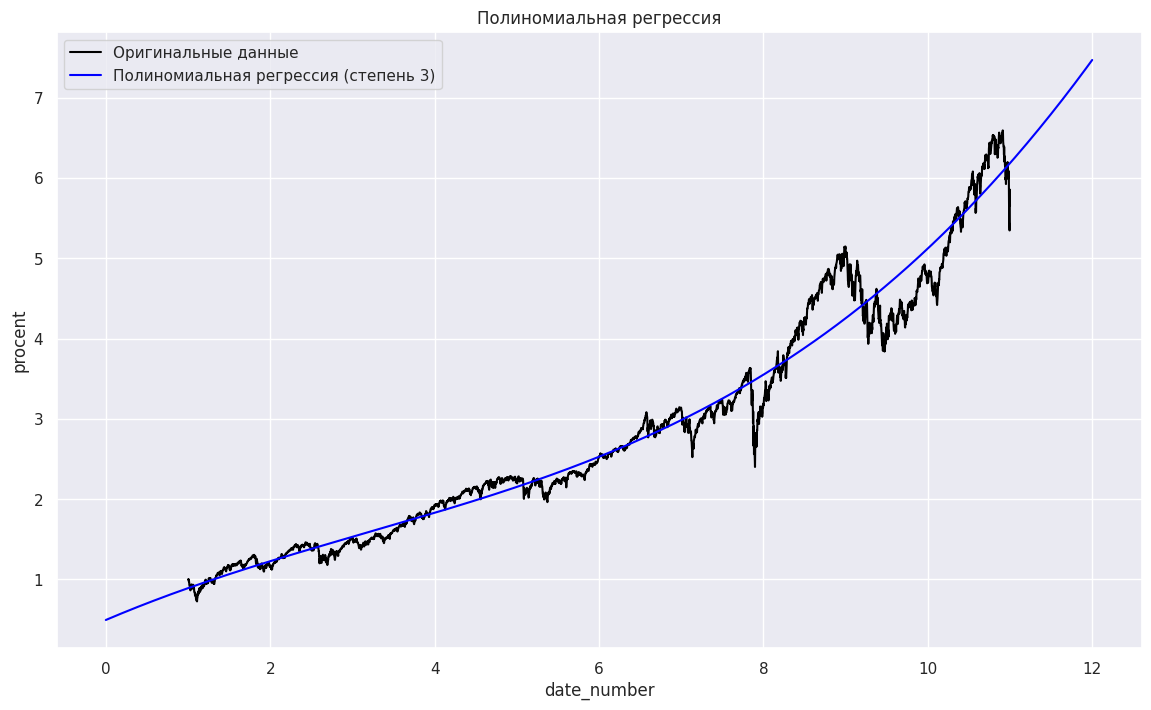

In [10]:
Xaxis = spx['date_number'].values
Yaxis = spx['procent'].values

# Степень полинома
degree = 3

# Создаем модель
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(Xaxis.reshape(-1, 1), Yaxis)

# Строим график
plt.figure(figsize=(14, 8))
plt.plot(Xaxis, Yaxis, c='black', label='Оригинальные данные')

# Получаем границы осей
ax = plt.gca()
xlim = ax.get_xlim()

# Предсказания модели
xx = np.linspace(math.floor(xlim[0]), math.ceil(xlim[1]), 500)
y_poly_predict = poly_model.predict(xx.reshape(-1, 1))

# Рисуем кривую предсказания
plt.plot(xx, y_poly_predict, color='blue', label=f'Полиномиальная регрессия (степень {degree})')

plt.legend()
plt.title("Полиномиальная регрессия")
plt.xlabel("date_number")
plt.ylabel("procent")
plt.grid(True)
plt.show()

### Все 3

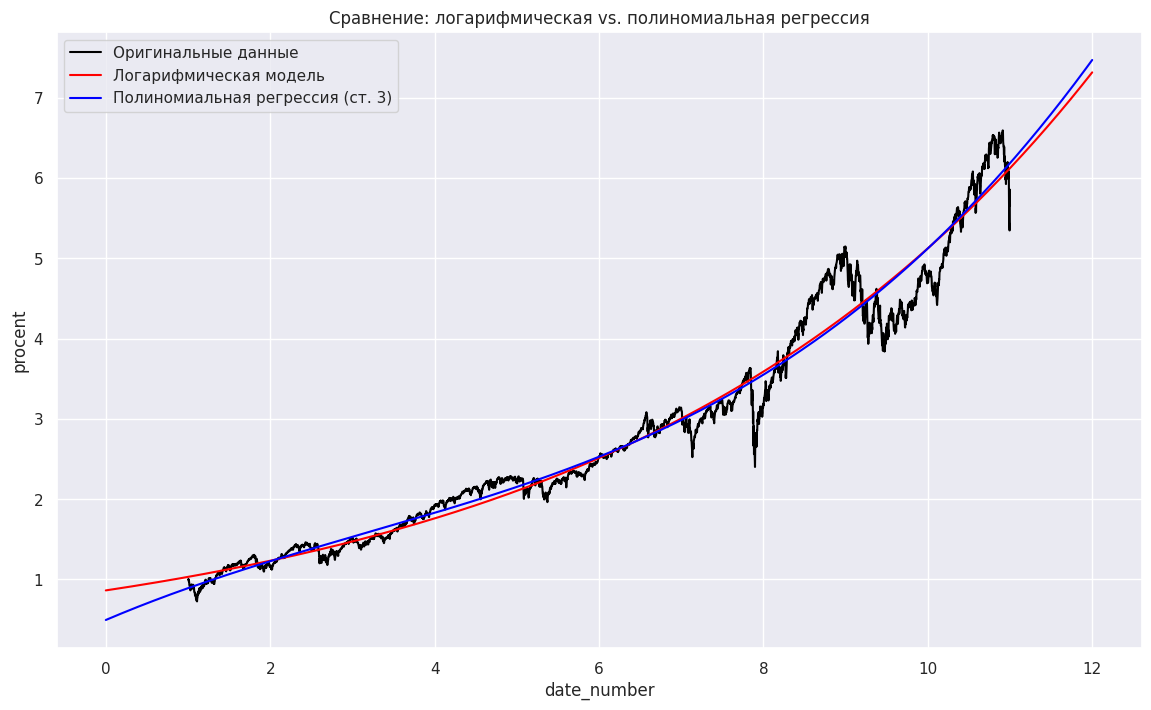

In [11]:
plt.figure(figsize=(14, 8))
plt.plot(Xaxis, Yaxis, c='black', label='Оригинальные данные')

# Логарифмическая модель
log_Yaxis = np.log(Yaxis)
log_model = LinearRegression()
log_model.fit(Xaxis.reshape(-1, 1), log_Yaxis)
log_y_pred = np.exp(log_model.predict(xx.reshape(-1, 1)))
plt.plot(xx, log_y_pred, label='Логарифмическая модель', color='red')

# Полиномиальная модель
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(Xaxis.reshape(-1, 1), Yaxis)
y_poly_pred = poly_model.predict(xx.reshape(-1, 1))
plt.plot(xx, y_poly_pred, label='Полиномиальная регрессия (ст. 3)', color='blue')

plt.legend()
plt.title("Сравнение: логарифмическая vs. полиномиальная регрессия")
plt.xlabel("date_number")
plt.ylabel("procent")
plt.grid(True)
plt.show()

### STL

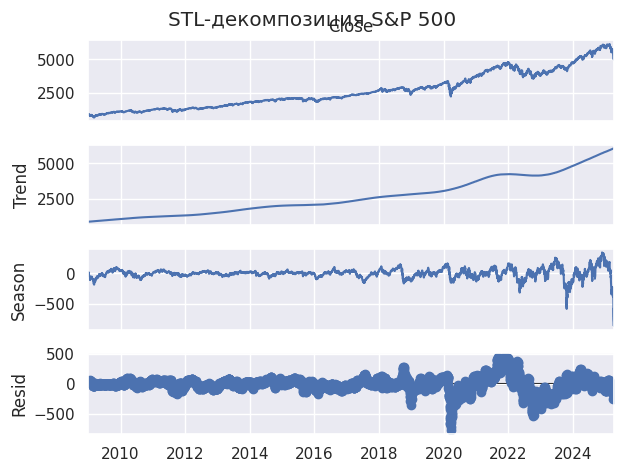

In [12]:
stl = STL(spx['Close'], period=365)
res = stl.fit()

# Отобразим
res.plot()
plt.suptitle("STL-декомпозиция S&P 500")
plt.show()

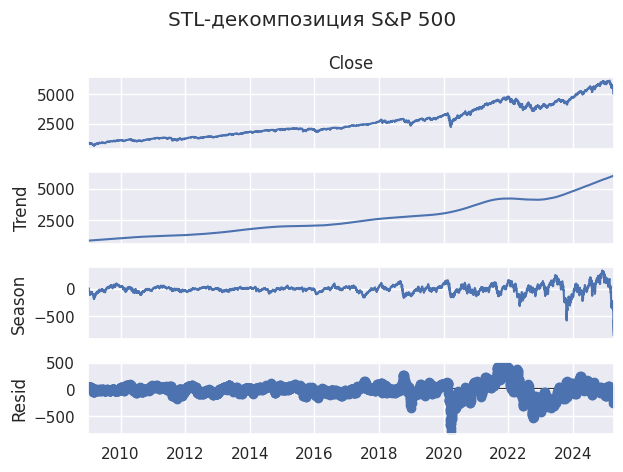

In [13]:
# Применим STL к колонке 'Close'
close_series = spx['Close'].dropna()
stl = STL(close_series, period=365)
res = stl.fit()

# Сохраняем компоненты обратно в DataFrame
spx.loc[close_series.index, 'trend'] = res.trend
spx.loc[close_series.index, 'seasonal'] = res.seasonal
spx.loc[close_series.index, 'resid'] = res.resid

# Визуализация всех компонентов STL
res.plot()
plt.suptitle("STL-декомпозиция S&P 500")
plt.tight_layout()
plt.show()

### STL more

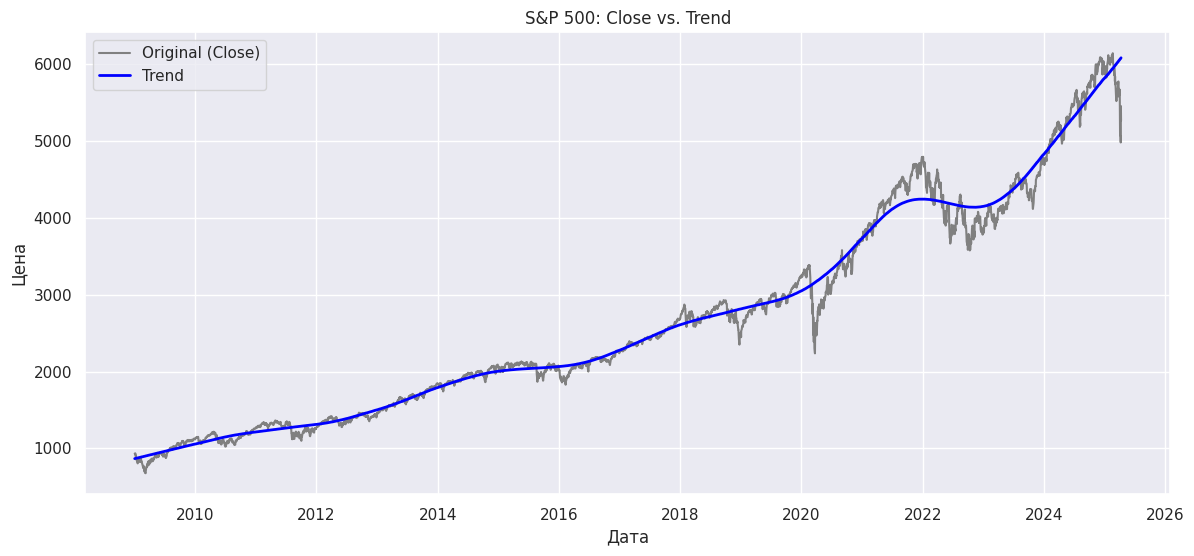

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(spx.index, spx['Close'], label='Original (Close)', color='gray')
plt.plot(spx.index, spx['trend'], label='Trend', color='blue', linewidth=2)
plt.title("S&P 500: Close vs. Trend")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
spx.head()

,Open,High,Low,Close,Volume,procent,date_number,trend,seasonal,resid
Price,,,,,,,,,,
2009-01-02,902.99,934.73,899.35,931.80,4048270000,1.000000,1.002443,866.988082,12.132761,52.679157
2009-01-05,929.17,936.63,919.53,927.45,5413910000,0.995332,1.004885,867.751753,9.387250,50.310997
2009-01-06,931.17,943.85,927.28,934.70,5392620000,1.003112,1.007328,868.515414,17.008061,49.176525
2009-01-07,927.45,927.45,902.37,906.65,4704940000,0.973009,1.009770,869.279065,-4.466220,41.837155
2009-01-08,905.73,910.00,896.81,909.73,4991550000,0.976315,1.012213,870.042704,-1.503452,41.190747


### Выделение аномалий

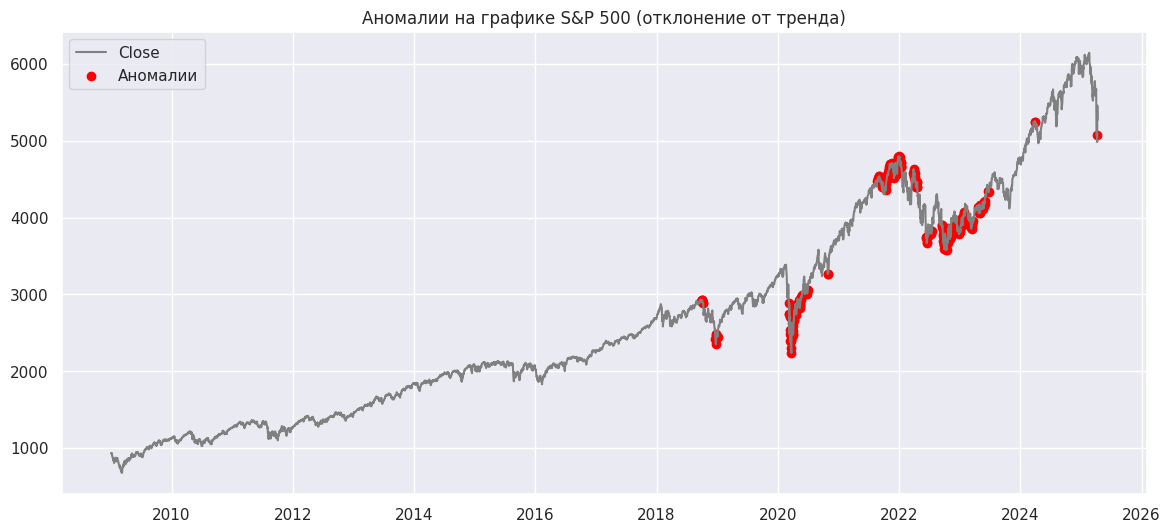

In [16]:
std_resid = spx['resid'].std()
threshold = 2 * std_resid

# Фильтруем аномалии
anomalies = spx[np.abs(spx['resid']) > threshold]

# Визуализируем
plt.figure(figsize=(14, 6))
plt.plot(spx.index, spx['Close'], label='Close', color='gray')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Аномалии')
plt.title("Аномалии на графике S&P 500 (отклонение от тренда)")
plt.legend()
plt.grid(True)
plt.show()

### Подготовка CSV-файла:

##### Сохрани spx в файл, который backtrader сможет считать:

In [17]:
spx[['Close', 'trend', 'Open', 'High', 'Low', 'Volume']].dropna().to_csv("data/spx_bt.csv", index=True, index_label='Date')

In [18]:
# Создаём стратегию
class STLStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.trend = self.datas[0].trend

    def next(self):
        if not self.position:
            if self.dataclose[0] < self.trend[0]:
                self.buy()
        else:
            if self.dataclose[0] > self.trend[0]:
                self.sell()

# Класс DataFeed с добавленным трендом
class PandasWithTrend(bt.feeds.PandasData):
    lines = ('trend',)
    params = (('trend', -1),)

In [19]:
# Загружаем данные
data = pd.read_csv('data/spx_bt.csv', index_col='Date', parse_dates=True)
datafeed = PandasWithTrend(dataname=data)

In [20]:
data.head()

,Close,trend,Open,High,Low,Volume
Date,,,,,,
2009-01-02,931.80,866.988082,902.99,934.73,899.35,4048270000
2009-01-05,927.45,867.751753,929.17,936.63,919.53,5413910000
2009-01-06,934.70,868.515414,931.17,943.85,927.28,5392620000
2009-01-07,906.65,869.279065,927.45,927.45,902.37,4704940000
2009-01-08,909.73,870.042704,905.73,910.00,896.81,4991550000


In [21]:
# Настраиваем "движок"
cerebro = bt.Cerebro()
cerebro.addstrategy(STLStrategy)
cerebro.adddata(datafeed)
cerebro.broker.setcash(100000.0)

In [22]:
# Запускаем
print(f'Начальный капитал: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Конечный капитал: {cerebro.broker.getvalue():.2f}')

# Отображение
cerebro.plot(iplot=False)
cerebro.plot()

Начальный капитал: 100000.00
Конечный капитал: 105516.28


[[<Figure size 640x480 with 8 Axes>]]